In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.linear_model import LinearRegression ,Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

import pickle
import json

# 1. Problem Statement

In [ ]:
Preidict sales

# 2. Data Gathering

In [2]:
df=pd.read_csv('data/Dummy Data HSS-Marketing and Sales Data.csv')
df

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866
4568,71.0,20.610685,6.545573,Nano,249.101915
4569,44.0,19.800072,5.096192,Micro,163.631457
4570,71.0,17.534640,1.940873,Macro,253.610411


# 3. EDA + Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


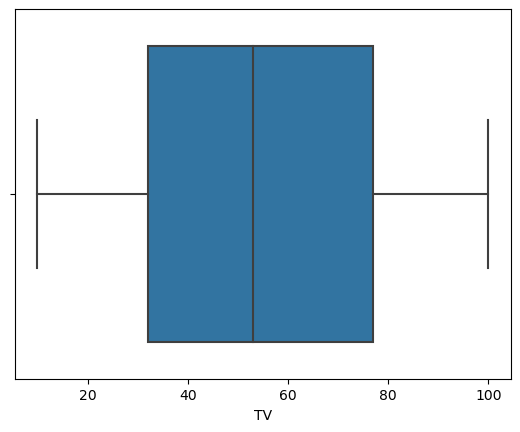

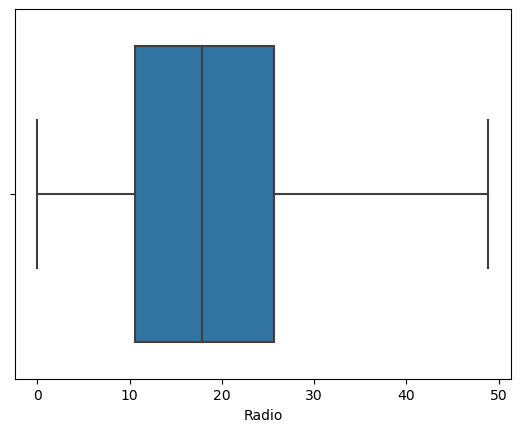

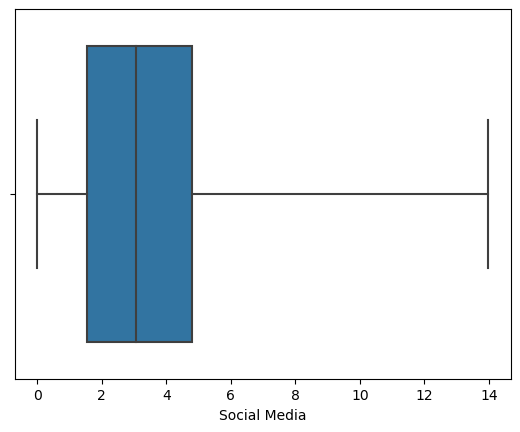

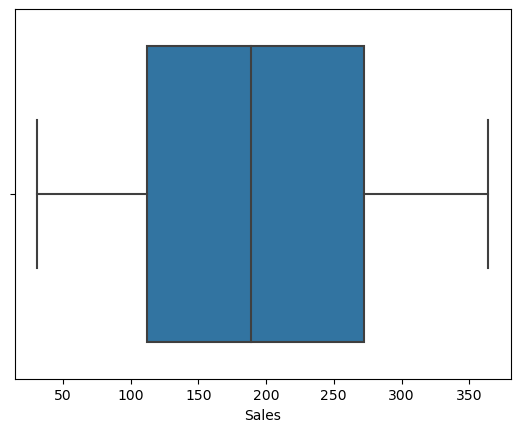

In [4]:
int_df=df.select_dtypes(exclude=object)
int_df.head()
for i in int_df.columns:
    sns.boxplot(x=int_df[i],whis=3)
    plt.show()

In [5]:
df.dropna(inplace=True)

### Encoding

In [6]:
df['Influencer'].value_counts()

Influencer
Mega     1152
Micro    1148
Nano     1134
Macro    1112
Name: count, dtype: int64

### One Hot Encoding

In [7]:
final_df = pd.get_dummies(df,dtype = int )
final_df

,TV,Radio,Social Media,Sales,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,0,1,0,0
1,13.0,9.237765,2.409567,46.677897,0,1,0,0
2,41.0,15.886446,2.913410,150.177829,0,1,0,0
3,83.0,30.020028,6.922304,298.246340,0,1,0,0
4,15.0,8.437408,1.405998,56.594181,0,0,1,0
...,...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,94.685866,0,0,1,0
4568,71.0,20.610685,6.545573,249.101915,0,0,0,1
4569,44.0,19.800072,5.096192,163.631457,0,0,1,0
4570,71.0,17.534640,1.940873,253.610411,1,0,0,0


In [8]:
df.select_dtypes(include=object)

,Influencer
0,Mega
1,Mega
2,Mega
3,Mega
4,Micro
...,...
4567,Micro
4568,Nano
4569,Micro
4570,Macro


<Axes: xlabel='TV', ylabel='Sales'>

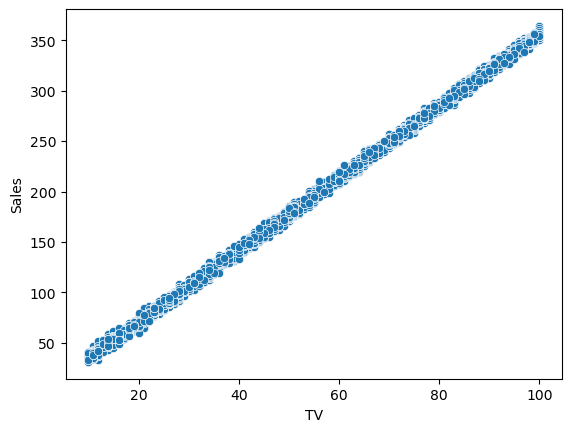

In [9]:
sns.scatterplot(x=df['TV'],y=df['Sales'])

# 4. Feature Selection

# Assumption 1 Linearity

In [10]:
final_df.corr()

,TV,Radio,Social Media,Sales,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
TV,1.000000,0.869158,0.527687,0.999497,0.022174,-0.012797,-0.005048,-0.004097
Radio,0.869158,1.000000,0.606338,0.868638,0.012859,-0.006580,0.002400,-0.008570
Social Media,0.527687,0.606338,1.000000,0.527446,0.014152,0.012437,-0.013923,-0.012582
Sales,0.999497,0.868638,0.527446,1.000000,0.022349,-0.012530,-0.005218,-0.004367
Influencer_Macro,0.022174,0.012859,0.014152,0.022349,1.000000,-0.331530,-0.330759,-0.328061
Influencer_Mega,-0.012797,-0.006580,0.012437,-0.012530,-0.331530,1.000000,-0.338633,-0.335871
Influencer_Micro,-0.005048,0.002400,-0.013923,-0.005218,-0.330759,-0.338633,1.000000,-0.335090
Influencer_Nano,-0.004097,-0.008570,-0.012582,-0.004367,-0.328061,-0.335871,-0.335090,1.000000


## Assumption 2 :No multicolinearity

In [11]:
x=final_df.drop('Sales',axis=1)
y=final_df['Sales']

lt=[]
for i in range(len(x.columns)):
    vif=variance_inflation_factor(x,i)
    lt.append(vif)

s=pd.DataFrame(lt , index=x.columns)
s

,0
TV,4.091850
Radio,4.667926
Social Media,1.582523
Influencer_Macro,2.148377
Influencer_Mega,2.133717
Influencer_Micro,2.128411
Influencer_Nano,2.116623


## 5. Model training

In [12]:
x=final_df.drop('Sales',axis=1)
y=final_df['Sales']
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.2)

In [13]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)

LinearRegression()

In [14]:
with open("linear_regression_model_on_MarketingAndSalesData.pkl", 'wb') as f:
    pickle.dump(lr_model,f)

# 6. Evaluation

## Evaluation on train dataset

In [17]:
y_pred_train=lr_model.predict(x_train)
mse=mean_squared_error(y_train,y_pred_train)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_train,y_pred_train)
print('Square root of MSE is :',rmse)
print('MAE :',mae)
print('Accuracy on train :',r2_score(y_train,y_pred_train))


Square root of MSE is : 2.961281474266308
MAE : 2.369057208473674
Accuracy on train : 0.9989875331858169


### Evaluation on test dataset

In [18]:
y_pred_test=lr_model.predict(x_test)
mse=mean_squared_error(y_test,y_pred_test)
rmse=np.sqrt(mse)
print('Square root of MSE is :',rmse)
print('Accuracy on test :',r2_score(y_test,y_pred_test))

Square root of MSE is : 2.899525810448428
Accuracy on test : 0.9990227382413662


## Assumption 3 : Normality of Residual

<Axes: xlabel='Sales', ylabel='Density'>

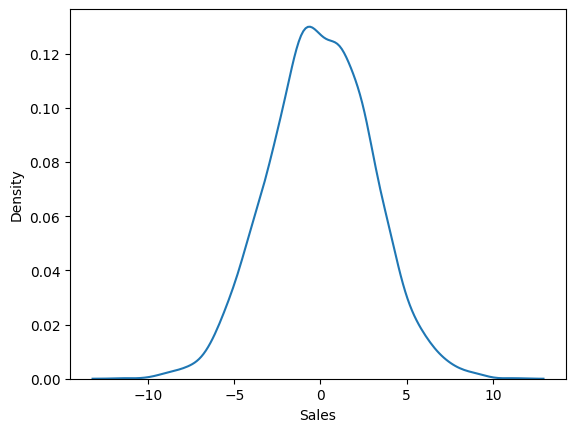

In [19]:
residual=y_train-y_pred_train
sns.kdeplot(residual)

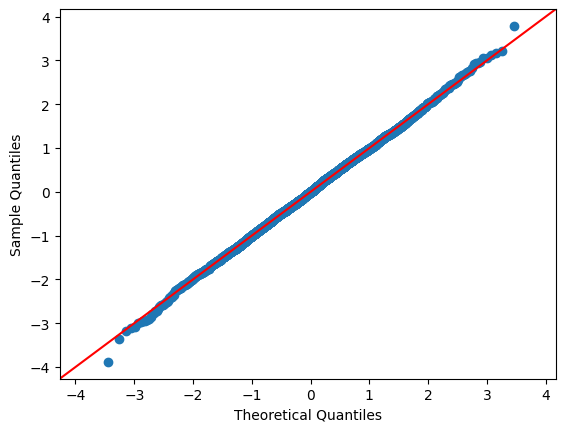

In [20]:
sm.qqplot(residual ,line='45',fit=True)
plt.show()


### Random Forest Regression

In [38]:
df=pd.read_csv('Dummy Data HSS-Marketing and Sales Data.csv')
df

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866
4568,71.0,20.610685,6.545573,Nano,249.101915
4569,44.0,19.800072,5.096192,Micro,163.631457
4570,71.0,17.534640,1.940873,Macro,253.610411


### Encoding

In [39]:
df.dropna(inplace=True)

In [40]:
df = pd.get_dummies(df, columns = ['Influencer'], dtype = int)

### Model Training

In [41]:
x = df.drop('Sales', axis = 1)
y = df.Sales
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=0)
x_train.shape

(3409, 7)

In [42]:
rf_reg = RandomForestRegressor(random_state = 1)
rf_reg.fit(x_train, y_train)

RandomForestRegressor(random_state=1)

In [43]:
rf_reg.feature_importances_

array([9.99049517e-01, 3.88179014e-04, 4.03216970e-04, 4.46957268e-05,
       3.79670491e-05, 3.72703331e-05, 3.91534168e-05])

### Model Evaluation 

In [49]:
# Train Data Evaluation
y_pred_train = rf_reg.predict(x_train)
y_pred_train[50:55]

array([138.3473157 , 305.52498455, 312.96661258, 158.23784296,
       110.20397898])

In [50]:
y_train[50:55]

2911    140.531193
2912    303.561435
3005    313.128378
3765    154.830419
2407    109.683208
Name: Sales, dtype: float64

In [51]:
# Train Data Evaluation
y_pred_train = rf_reg.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print('MAE :',mae)

r2_value = r2_score(y_train, y_pred_train)
print("R-squared Value :",r2_value)

MSE : 1.522907531068538
RMSE : 1.2340613967986107
MAE : 0.9699653605552919
R-squared Value : 0.9998234197040095


In [53]:
# Test Data Evaluation
y_pred = rf_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE :',mae)

r2_value = r2_score(y_test, y_pred)
print("R-squared Value :",r2_value)

MSE : 11.356842889955187
RMSE : 3.3699915266889304
MAE : 2.6902786931365856
R-squared Value : 0.9986975584503228


### Hyperparameter Tuning

In [54]:
rf_reg = RandomForestRegressor(max_features='sqrt',random_state=0,
                               bootstrap=True,
                               oob_score=True,
                              n_jobs = -1)
hyp_grid = {"n_estimators":np.arange(10,200,10),
            "criterion" : ['squared_error','absolute_error'],
            "max_depth" : np.arange(4,8),
            "min_samples_split" : range(10,15),
            "min_samples_leaf" : range(6,10)}

gscv_rf_reg = GridSearchCV(rf_reg, hyp_grid , cv = 3, n_jobs=-1)
gscv_rf_reg.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features='sqrt', n_jobs=-1,
                                             oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': array([4, 5, 6, 7]),
                         'min_samples_leaf': range(6, 10),
                         'min_samples_split': range(10, 15),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])})

In [55]:
gscv_rf_reg.best_estimator_

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=10, n_estimators=90, n_jobs=-1,
                      oob_score=True, random_state=0)

In [56]:
# Train Data Evaluation
rf_reg = gscv_rf_reg.best_estimator_
rf_reg.fit(x_train, y_train)

y_pred_train = rf_reg.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print('MAE :',mae)

r2_value = r2_score(y_train, y_pred_train)
print("R-squared Value :",r2_value)

MSE : 135.1386419624923
RMSE : 11.62491470775129
MAE : 8.287675647661572
R-squared Value : 0.984330748314869


In [57]:
# Test Data Evaluation
y_pred = rf_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE :',mae)

r2_value = r2_score(y_test, y_pred)
print("R-squared Value :",r2_value)

MSE : 172.89937416188283
RMSE : 13.149120661165249
MAE : 9.466830887098604
R-squared Value : 0.980171308962916


### KNN regression

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('Dummy Data HSS-Marketing and Sales Data.csv')
df

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866
4568,71.0,20.610685,6.545573,Nano,249.101915
4569,44.0,19.800072,5.096192,Micro,163.631457
4570,71.0,17.534640,1.940873,Macro,253.610411


### EDA

In [4]:
df.dropna(inplace=True)

In [8]:
df = pd.get_dummies(df,dtype = int )
df

,TV,Radio,Social Media,Sales,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,0,1,0,0
1,13.0,9.237765,2.409567,46.677897,0,1,0,0
2,41.0,15.886446,2.913410,150.177829,0,1,0,0
3,83.0,30.020028,6.922304,298.246340,0,1,0,0
4,15.0,8.437408,1.405998,56.594181,0,0,1,0
...,...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,94.685866,0,0,1,0
4568,71.0,20.610685,6.545573,249.101915,0,0,0,1
4569,44.0,19.800072,5.096192,163.631457,0,0,1,0
4570,71.0,17.534640,1.940873,253.610411,1,0,0,0


In [9]:
df.describe()

,TV,Radio,Social Media,Sales,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
count,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000
mean,54.062912,18.157533,3.323473,192.413332,0.244611,0.253410,0.252530,0.249450
std,26.104942,9.663260,2.211254,93.019873,0.429903,0.435011,0.434511,0.432742
min,10.000000,0.000684,0.000031,31.199409,0.000000,0.000000,0.000000,0.000000
25%,32.000000,10.555355,1.530822,112.434612,0.000000,0.000000,0.000000,0.000000
50%,53.000000,17.859513,3.055565,188.963678,0.000000,0.000000,0.000000,0.000000
75%,77.000000,25.640603,4.804919,272.324236,0.000000,1.000000,1.000000,0.000000
max,100.000000,48.871161,13.981662,364.079751,1.000000,1.000000,1.000000,1.000000


### Model Training

In [10]:
x = df.drop('Sales', axis = 1)
y = df['Sales']
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=2, test_size=0.2)


In [11]:
knn_reg =  KNeighborsRegressor(n_neighbors=5, p=2)
knn_reg.fit(x_train, y_train)

KNeighborsRegressor()

### Evaluation

In [12]:
knn_reg.score(x_train, y_train)

0.9990406536874975

In [13]:
knn_reg.score(x_test, y_test)

0.9985012086951405

In [14]:
# Training Data Evaluation 
y_pred_train = knn_reg.predict(x_train)
mse = mean_squared_error(y_train, y_pred_train)
print("MSE :", mse)

rmse = np.sqrt(mse)
print("RMSE :", rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :", mae)

r2_value = r2_score(y_train, y_pred_train)
print("R2 value :",r2_value)

MSE : 8.306320409192766
RMSE : 2.8820687724606375
MAE : 2.300554844754125
R2 value : 0.9990406536874975


In [15]:
# Testing Data Evaluation 
y_pred = knn_reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)

rmse = np.sqrt(mse)
print("RMSE :", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)

r2_value = r2_score(y_test, y_pred)
print("R2 value :",r2_value)

MSE : 12.914838497779773
RMSE : 3.593722095234935
MAE : 2.869240291116484
R2 value : 0.9985012086951405


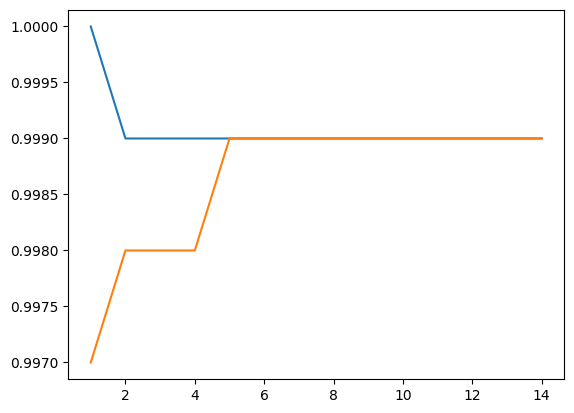

In [16]:
k_values = np.arange(1,15)
train_r2_score = []
test_r2_score = []
for k in k_values:
    knn_reg =  KNeighborsRegressor(n_neighbors=k, p=2)
    knn_reg.fit(x_train, y_train)
    train_r2_score.append(np.around(knn_reg.score(x_train, y_train),3))
    test_r2_score.append(np.around(knn_reg.score(x_test, y_test),3))

plt.plot(k_values, train_r2_score)
plt.plot(k_values, test_r2_score)

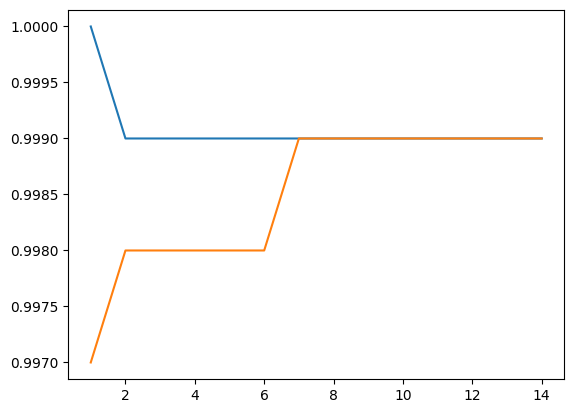

In [17]:
k_values = np.arange(1,15)
train_r2_score = []
test_r2_score = []
for k in k_values:
    knn_reg =  KNeighborsRegressor(n_neighbors=k, p=1)
    knn_reg.fit(x_train, y_train)
    train_r2_score.append(np.around(knn_reg.score(x_train, y_train),3))
    test_r2_score.append(np.around(knn_reg.score(x_test, y_test),3))

plt.plot(k_values, train_r2_score)
plt.plot(k_values, test_r2_score)

### Final Model

In [18]:
knn_reg =  KNeighborsRegressor(n_neighbors=5, p=2)
knn_reg.fit(x_train, y_train)
print(knn_reg.score(x_train, y_train))
print(knn_reg.score(x_test, y_test))

0.9990406536874975
0.9985012086951405
